# Linear Risk model

A risk score model for retinopathy in diabetes patients using logistic regression.

## 1.  Import necessary packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

## 2.  Exploring data
The features (`X`) include the following fields:
* Age: (years)
* Systolic_BP: Systolic blood pressure (mmHg)
* Diastolic_BP: Diastolic blood pressure (mmHg)
* Cholesterol: (mg/DL)

The target (`y`) is an indicator of whether or not the patient developed retinopathy.

* y = 1 : patient has retinopathy.
* y = 0 : patient does not have retinopathy.

In [2]:
X = pd.read_csv('X_data.csv', index_col=0)
y_data = pd.read_csv('y_data.csv', index_col=0)
y = y_data['y']

In [3]:
X.head()

,Age,Systolic_BP,Diastolic_BP,Cholesterol
0,77.196340,85.288742,80.021878,79.957109
1,63.529850,99.379736,84.852361,110.382411
2,69.003986,111.349455,109.850616,100.828246
3,82.638210,95.056128,79.666851,87.066303
4,78.346286,109.154591,90.713220,92.511770


In [4]:
y.head()

0    1.0
1    1.0
2    1.0
3    1.0
4    1.0
Name: y, dtype: float64

Split the data into train and test sets using a 75/25 split.

In [5]:
X_train_raw, X_test_raw, y_train, y_test = train_test_split(X, y, train_size=0.75, random_state=0)

Plot the histogram of each feature

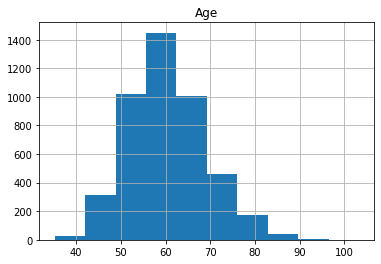

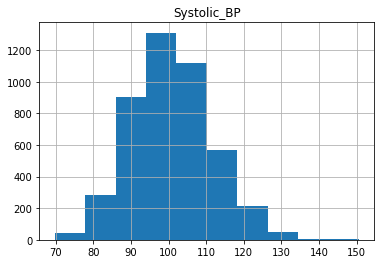

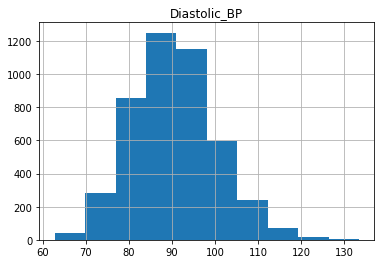

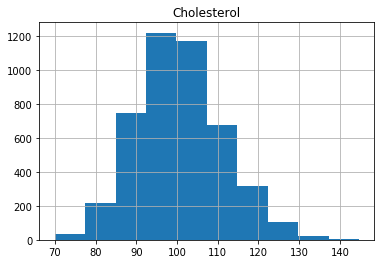

In [6]:
for col in X_train_raw.columns:
    X_train_raw.loc[:, col].hist()
    plt.title(col)
    plt.show()

As we can see, the distributions have a generally bell shaped distribution, but with slight rightward skew.
We can transform our data to be closer to a normal distribution by removing the skew. One way to remove the skew is by applying the log function to the data and see what effect it produces.

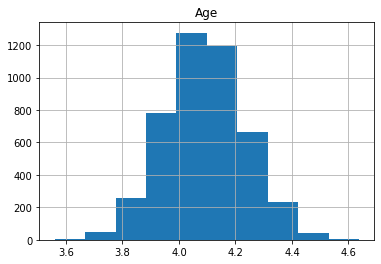

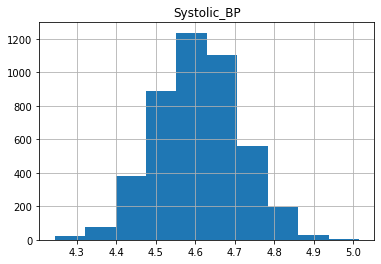

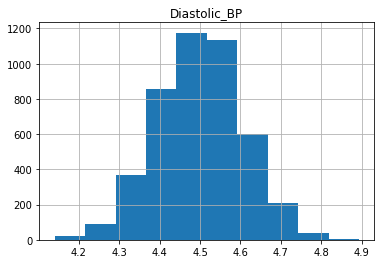

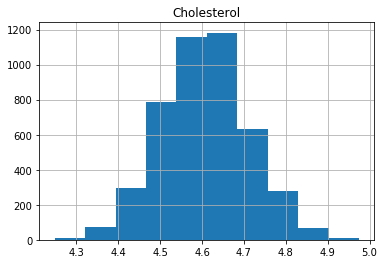

In [7]:
for col in X_train_raw.columns:
    np.log(X_train_raw.loc[:, col]).hist()
    plt.title(col)
    plt.show()

Let's standardize the distribution so that it has a mean of zero and standard deviation of 1

In [8]:
def make_standard_normal(df_train, df_test):
    """
    In order to make the data closer to a normal distribution, take log
    transforms to reduce the skew.
    Then standardize the distribution with a mean of zero and standard deviation of 1. 
    """
    
    df_train_unskewed = np.log(df_train)
    df_test_unskewed = np.log(df_test)
    
    #calculate the mean and standard deviation of the training set
    mean = df_train_unskewed.mean(axis=0)
    stdev = df_train_unskewed.std(axis=0)
    
    # standardize the training set
    df_train_standardized = (df_train_unskewed - mean)/stdev
    
    # standardize the test set
    df_test_standardized = (df_test_unskewed - mean)/stdev
    
    return df_train_standardized, df_test_standardized

Use the function that you just implemented to make the data distribution closer to a standard normal distribution.

In [9]:
X_train, X_test = make_standard_normal(X_train_raw, X_test_raw)

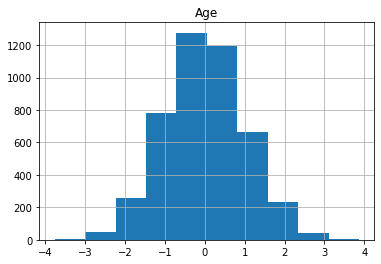

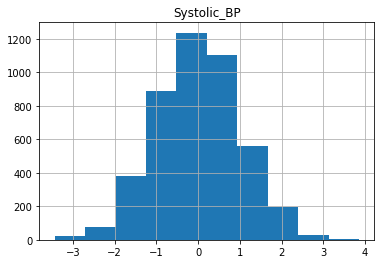

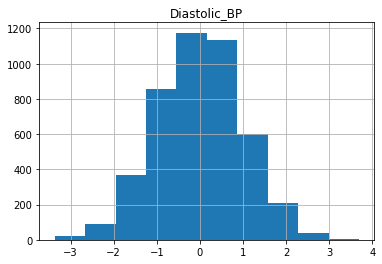

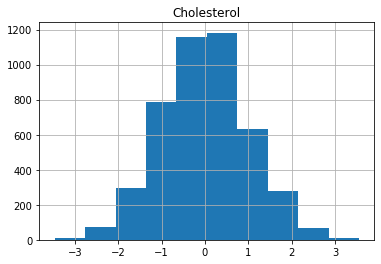

In [10]:
for col in X_train.columns:
    X_train[col].hist()
    plt.title(col)
    plt.show()

## 3.  Build the model
Building the risk model by training logistic regression with the data.

In [11]:
def lr_model(X_train, y_train):
    """
    Logistic Regression model
    """
    model = LogisticRegression()
    model.fit(X_train, y_train)
    
    return model

In [12]:
model_X = lr_model(X_train, y_train)

C:\Users\Hiren Kelaiya\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


## 4.  Evaluate the model using concordance-index (c-index)

* The c-index measures the discriminatory power of a risk score. 
* Intuitively, a higher c-index indicates that the model's prediction is in agreement with the actual outcomes of a pair of patients.
* The formula for the c-index is

$$ \mbox{c-index} = \frac{\mbox{concordant_pairs} + 0.5 \times \mbox{risk_ties}}{\mbox{permissible_pairs}} $$

* A permissible pair is a pair of patients who have different outcomes.
* A concordant pair is a permissible pair in which the patient with the higher risk score also has the worse outcome.
* A risk tie is a permissible pair where the patients have the same risk score.

In [13]:
def c_index(y_true, scores):
    '''
    Input:
    y_true (np.array): a 1-D array of true binary outcomes (values of zero or one)
        0: patient does not get the disease
        1: patient does get the disease
    scores (np.array): a 1-D array of corresponding risk scores output by the model

    Output:
    c_index (float): (concordant pairs + 0.5*ties) / number of permissible pairs
    '''
    n = len(y_true)
    assert len(scores) == n

    concordant = 0
    permissible = 0
    ties = 0
    
    # using two nested for loops to go through all unique pairs of patients
    for i in range(n):
        for j in range(i+1, n):
            
            # Check if the pair is permissible (the patient outcomes are different)
            if y_true[i] != y_true[j]:
                # Count the pair if it's permissible
                permissible += 1

                # For permissible pairs, check if they are concordant or are ties

                # check for ties in the score
                if scores[i] == scores[j]:
                    # count the tie
                    ties += 1
                    # if it's a tie, we don't need to check patient outcomes, continue to the top of the for loop.
                    continue

                # case 1: patient i doesn't get the disease, patient j does
                if y_true[i] == 0.0 and y_true[j] == 1.0:
                    # Check if patient i has a lower risk score than patient j
                    if scores[i] < scores[j]:
                        # count the concordant pair
                        concordant += 1
                    # Otherwise if patient i has a higher risk score, it's not a concordant pair.
                    
                # case 2: patient i gets the disease, patient j does not
                if y_true[i] == 1.0 and y_true[j] == 0.0 == 0:
                    # Check if patient i has a higher risk score than patient j
                    if scores[i] > scores[j]:
                        #count the concordant pair
                        concordant += 1
                    # Otherwise if patient i has a lower risk score, it's not a concordant pair.
                    
    # calculate the c-index using the count of permissible pairs, concordant pairs, and tied pairs.
    c_index = (concordant + 0.5 * ties)/ permissible
    
    return c_index

To get the predicted probabilities, we use the `predict_proba` method. This method will return the result from the model *before* it is converted to a binary 0 or 1. For each input case, it returns an array of two values which represent the probabilities for both the negative case (patient does not get the disease) and positive case (patient the gets the disease). 

In [14]:
scores = model_X.predict_proba(X_test)[:, 1]
c_index_X_test = c_index(y_test.values, scores)
print(f"c-index on test set is {c_index_X_test:.4f}")

c-index on test set is 0.8182


Let's plot the coefficients to see which variables (patient features) are having the most effect.

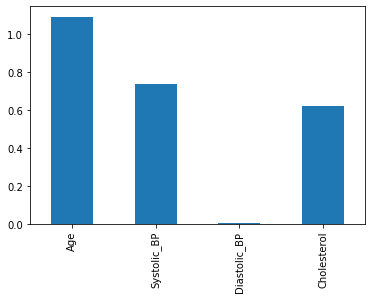

In [15]:
coeffs = pd.DataFrame(data = model_X.coef_, columns = X_train.columns)
coeffs.T.plot.bar(legend=None);

## 5. Improve the Model

Including interaction terms is one way to improve your model. 
* An interaction term is the product of two variables (i.e. features).

In [16]:
def add_interactions(X):
    """
    Add interaction terms between columns to dataframe.

    Args:
    X (dataframe): Original data

    Returns:
    X_int (dataframe): Original data with interaction terms appended. 
    """
    features = X.columns
    m = len(features)
    X_int = X.copy(deep=True)

    # 'i' loops through all features in the original dataframe X
    for i in range(m):
        
        feature_i_name = features[i]
        feature_i_data = X[feature_i_name]
        
        # choose the index of column 'j' to be greater than column i
        for j in range(i+1, m):
            
            feature_j_name = features[j]
            feature_j_data = X[feature_j_name]
            
            # create the name of the interaction feature by combining both names
            feature_i_j_name = f"{feature_i_name}_x_{feature_j_name}"
            X_int[feature_i_j_name] = feature_i_data * feature_j_data

    return X_int

In [17]:
X_train_int = add_interactions(X_train)
X_test_int = add_interactions(X_test)

## 6. Evaluate the improved Model

In [18]:
model_X_int = lr_model(X_train_int, y_train)

C:\Users\Hiren Kelaiya\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [20]:
scores_X = model_X.predict_proba(X_test)[:, 1]
c_index_X_int_test = c_index(y_test.values, scores_X)

scores_X_int = model_X_int.predict_proba(X_test_int)[:, 1]
c_index_X_int_test = c_index(y_test.values, scores_X_int)

print(f"c-index on test set without interactions is {c_index_X_test:.4f}")
print(f"c-index on test set with interactions is {c_index_X_int_test:.4f}")

c-index on test set without interactions is 0.8182
c-index on test set with interactions is 0.8281


Here we can see that the model with interaction terms performs a bit better than the model without interactions.

Now let's take another look at the model coefficients to try and see which variables made a difference. Plot the coefficients and report which features seem to be the most important.

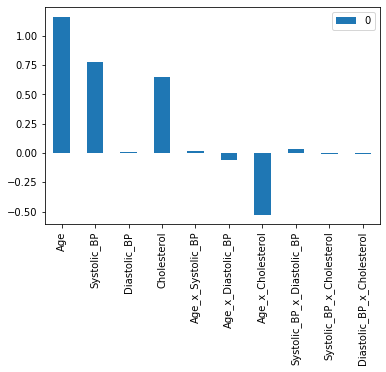

In [21]:
int_coeffs = pd.DataFrame(data = model_X_int.coef_, columns = X_train_int.columns)
int_coeffs.T.plot.bar();

From the above plot, Age, Systolic_BP, and Cholesterol have a positive coefficient. This means that a higher value in these three features leads to a higher prediction probability for the disease. Here in the plot, the interaction of Age x Cholesterol has a negative coefficient. This means that a higher value for the Age x Cholesterol product reduces the prediction probability for the disease.

To understand the effect of interaction terms, let's compare the output of the model which is trained on sample cases with and without the interaction.

In [26]:
index = 3432
case = X_train_int.iloc[index, :]
print(case)

Age                           2.502061
Systolic_BP                   1.713547
Diastolic_BP                  0.268265
Cholesterol                   2.146349
Age_x_Systolic_BP             4.287400
Age_x_Diastolic_BP            0.671216
Age_x_Cholesterol             5.370296
Systolic_BP_x_Diastolic_BP    0.459685
Systolic_BP_x_Cholesterol     3.677871
Diastolic_BP_x_Cholesterol    0.575791
Name: 5970, dtype: float64


Here we can see that they have above average Age and Cholesterol. We can now see what the original model would have output by making the value for Cholesterol and Age to zero.

In [27]:
new_case = case.copy(deep=True)
new_case.loc["Age_x_Cholesterol"] = 0
new_case

Age                           2.502061
Systolic_BP                   1.713547
Diastolic_BP                  0.268265
Cholesterol                   2.146349
Age_x_Systolic_BP             4.287400
Age_x_Diastolic_BP            0.671216
Age_x_Cholesterol             0.000000
Systolic_BP_x_Diastolic_BP    0.459685
Systolic_BP_x_Cholesterol     3.677871
Diastolic_BP_x_Cholesterol    0.575791
Name: 5970, dtype: float64

In [28]:
print(f"Output with interaction: \t{model_X_int.predict_proba([case.values])[:, 1][0]:.4f}")
print(f"Output without interaction: \t{model_X_int.predict_proba([new_case.values])[:, 1][0]:.4f}")

Output with interaction: 	0.9448
Output without interaction: 	0.9965


## 7. Conclusion

It is clear that the model is less confident in its prediction with the interaction term than without (the prediction value is lower when including the interaction term). With the interaction term, the model has adjusted for the fact that the effect of high cholesterol becomes less important for older patients compared to younger patients.